# Evaluating baseline performance

In this notebook, we illustrate the performance of the baseline box model against the official training split.

In [10]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

if os.path.basename(os.getcwd()) == 'examples':
    sys.path.append("../")
    
import milliontrees

In [11]:
from deepforest import main
m = main.deepforest()
m.load_model("weecology/deepforest-tree")

Reading config file: /blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /blue/ewhite/b.weinstein/miniconda3/envs/MillionTrees/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


     xmin   ymin   xmax   ymax label     score    image_path  \
0   330.0  342.0  373.0  391.0  Tree  0.802979  OSBS_029.png   
1   216.0  206.0  248.0  242.0  Tree  0.778803  OSBS_029.png   
2   325.0   44.0  363.0   82.0  Tree  0.751572  OSBS_029.png   
3   261.0  238.0  296.0  276.0  Tree  0.748605  OSBS_029.png   
4   173.0    0.0  229.0   33.0  Tree  0.738210  OSBS_029.png   
5   258.0  198.0  291.0  230.0  Tree  0.716250  OSBS_029.png   
6    97.0  305.0  152.0  363.0  Tree  0.711665  OSBS_029.png   
7    52.0   72.0   85.0  108.0  Tree  0.698782  OSBS_029.png   
8   292.0  368.0  332.0  400.0  Tree  0.688486  OSBS_029.png   
9   249.0   51.0  277.0   81.0  Tree  0.688165  OSBS_029.png   
10  317.0  181.0  345.0  210.0  Tree  0.686540  OSBS_029.png   
11   18.0  346.0   57.0  388.0  Tree  0.668806  OSBS_029.png   
12  272.0  330.0  305.0  367.0  Tree  0.666737  OSBS_029.png   
13  277.0    0.0  311.0   31.0  Tree  0.654230  OSBS_029.png   
14  195.0  339.0  227.0  371.0  Tree  0.

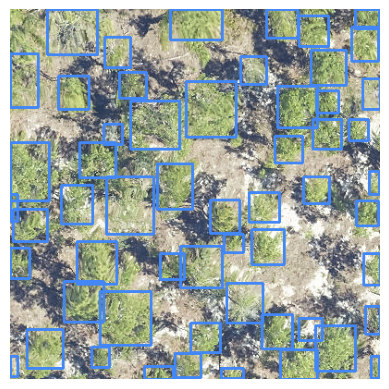

In [12]:
from deepforest import get_data
from deepforest.visualize import plot_results
from deepforest.utilities import read_file

boxes = m.predict_image(path=get_data("OSBS_029.png"))

print(boxes)
plot_results(boxes)

In [13]:
# Load the box dataset
from milliontrees import get_dataset
from milliontrees.common.data_loaders import get_eval_loader

box_dataset = get_dataset("TreeBoxes", root_dir="/orange/ewhite/DeepForest/MillionTrees/")
box_test_data = box_dataset.get_subset("test")

The general workflow is to yield a image, and targets (orange), make a predictions (blue) and evaluate the metric. 

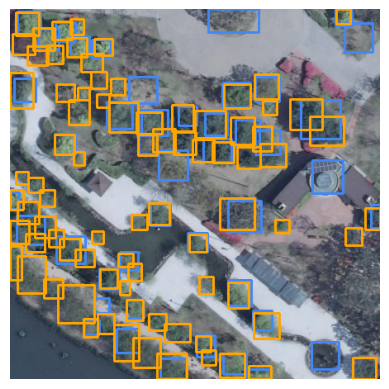

In [14]:
metadata, image, targets = box_test_data[0]
image_path = box_dataset._filename_id_to_code[int(metadata[0])]
image_path = os.path.join(box_dataset._data_dir._str, "images",image_path)

# Load the image, in this case DeepForest expects a numpy array, channels first, 0-255.
channels_first = image.permute(1, 2, 0).numpy() * 255
boxes = m.predict_image(channels_first)
ground_truth = read_file(pd.DataFrame(targets["y"].numpy(),columns=["xmin","ymin","xmax","ymax"]))
ground_truth["label"] = "Tree"
plot_results(boxes, ground_truth, image=channels_first.astype("int32"))

## Evaluation example

Every model will output predictions in a slightly different way. MillionTrees expects a dictionary of tensors, same format between predictions and ground truth.

In [15]:
y_pred = {}
y_pred["y"] = torch.tensor(boxes[["xmin", "ymin", "xmax","ymax"]].values.astype("float32"))
y_pred["labels"] = torch.tensor(boxes.label.apply(
        lambda x: m.label_dict[x]).values.astype(np.int64))
y_pred["scores"] = torch.tensor(boxes.score.values.astype("float32"))

# The eval method takes in batches, so wrap this one example in a list
box_test_data.eval([y_pred], [targets], metadata=torch.unsqueeze(metadata, dim=0))

({'detection_acc_avg': 0.34408602118492126,
  'detection_acc_source_id:0': 0.34408602118492126,
  'count_source_id:0': 1.0,
  'detection_acc_source_id:1': nan,
  'count_source_id:1': 0.0,
  'detection_acc_source_id:2': nan,
  'count_source_id:2': 0.0,
  'detection_acc_source_id:3': nan,
  'count_source_id:3': 0.0,
  'detection_acc_source_id:4': nan,
  'count_source_id:4': 0.0,
  'detection_acc_source_id:5': nan,
  'count_source_id:5': 0.0,
  'detection_acc_source_id:6': nan,
  'count_source_id:6': 0.0,
  'detection_acc_source_id:7': nan,
  'count_source_id:7': 0.0,
  'detection_acc_source_id:8': nan,
  'count_source_id:8': 0.0,
  'detection_acc_wg': 0.34408602118492126,
  'detection_acc_avg_dom': np.float64(nan)},
 'Average detection_acc across source: nan\nAverage detection_acc: 0.344\n  source_id = 0  [n =      1]:\tdetection_acc = 0.344\nWorst-group detection_acc: 0.344\n')

There are 72 batches in the test loader


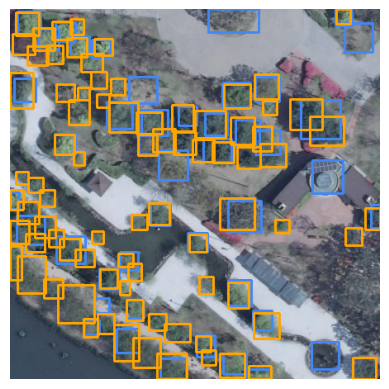

In [ ]:
test_loader = get_eval_loader("standard", box_test_data, batch_size=16)

# Print the length of the test loader
print("There are {} batches in the test loader".format(len(test_loader)))

# Suppress user warnings
import warnings
warnings.filterwarnings("ignore")

# Get predictions for the full test set
all_y_pred = []
all_y_true = []

batch_index = 0
for batch in test_loader:
    metadata, images, targets  = batch
    for image_metadata, image, image_targets in zip(metadata,images, targets):
        basename = box_dataset._filename_id_to_code[int(image_metadata[0])]
        #image_path = os.path.join(box_dataset._data_dir._str, "images",basename)
        # Deepforest likes 0-255 data, channels first
        channels_first = image.permute(1, 2, 0).numpy() * 255
        pred = m.predict_image(channels_first)
        pred["image_path"] = basename
        pred.root_dir = os.path.join(box_dataset._data_dir._str, "images")
        if pred is None:
            y_pred = {}
            y_pred["y"] = torch.zeros(4)
            y_pred["labels"] = torch.zeros(1)
            y_pred["scores"] = torch.zeros(1)
        else:
            # Reformat to million trees format
            y_pred = {}
            y_pred["y"] = torch.tensor(pred[["xmin", "ymin", "xmax","ymax"]].values.astype("float32"))
            y_pred["labels"] = torch.tensor(pred.label.apply(
                    lambda x: m.label_dict[x]).values.astype(np.int64))
            y_pred["scores"] = torch.tensor(pred.score.values.astype("float32"))

        if batch_index % 100 == 0:
            ground_truth = read_file(pd.DataFrame(image_targets["y"].numpy(),columns=["xmin","ymin","xmax","ymax"]))
            ground_truth["label"] = "Tree"
            plot_results(pred, ground_truth, image=channels_first.astype("int32"))
        
        all_y_pred.extend([y_pred])
        all_y_true.extend(targets)
        batch_index += 1

# Evaluate
box_dataset.eval(all_y_pred, all_y_true, box_test_data.metadata_array)